# Assignment 2 - QKD : BB84

Assignments for Endsem.

1. Implement BB84, Ekert and SQKD in Qiskit and provide the raw key generated at Alice's as well as Bob's ends.
2. Implement CNOT attack on BB84, Ekert and SQKD. Provide the strings generated at Alice's place, Bob's place and Eve's end.

In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

# BB84 :Methods to encode and measure bits

In [2]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

# Method to discard useless bits

In [3]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            good_bits.append(bits[q])
    return good_bits

# BB84 : Alice and Bob exchages keys 


In [4]:
np.random.seed(seed=0)
n = 30

alice_bits = randint(2, size=n)

alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

print(alice_key)
print(bob_key)

[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]


# Ekert : Create entangled electrons

In [21]:
# Initialing the circuit again
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

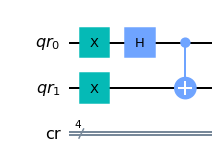

In [22]:
#creating entangled electrons

qc = QuantumCircuit(qr, cr)
qc.x(qr[0])
qc.x(qr[1])
qc.h(qr[0])
qc.cx(qr[0],qr[1])

qc.draw(output="mpl")

# qr[0] belongs to Alice
# qr[1] belongs to Bob

## Measurement Circuits

In [23]:
def measure_ekert_alice(q, c, qr,cr):
    # measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
    a1 = QuantumCircuit(q, c, name='a1')
    a1.h(qr)
    a1.measure(qr,cr)
    # measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
    a2 = QuantumCircuit(q, c, name='a2')
    a2.s(qr)
    a2.h(qr)
    a2.t(qr)
    a2.h(qr)
    a2.measure(qr,cr)
    # measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
    a3 = QuantumCircuit(q, c, name='a3')
    a3.measure(qr,cr)
    return [a1,a2,a3]

def measure_ekert_bob(q, c, qr,cr):
    # measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
    b1 = QuantumCircuit(q, c, name='b1')
    b1.s(qr)
    b1.h(qr)
    b1.t(qr)
    b1.h(qr)
    b1.measure(qr,cr)
    # measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
    b2 = QuantumCircuit(q, c, name='b2')
    b2.measure(qr,cr)
    # measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
    b3 = QuantumCircuit(q, c, name='b3')
    b3.s(qr)
    b3.h(qr)
    b3.tdg(qr)
    b3.h(qr)
    b3.measure(qr,cr)
    return [b1,b2,b3]


## Ekert : Preparing bits

In [24]:
n = 100

a_bases = [randint(1, 3) for i in range(n)]
b_bases = [randint(1, 3) for i in range(n)]

circuits = []

for i in range(n):
    circuitName = str(i) + ':A' + str(a_bases[i]) + '_B' + str(b_bases[i])
    a_measures = measure_ekert_alice(qr, cr, qr[0],cr[0])
    b_measures = measure_ekert_bob(qr, cr, qr[1],cr[1])
    circuitName = qc + a_measures[a_bases[i]-1] + b_measures[b_bases[i]-1] 
    circuits.append(circuitName)



circuit1621


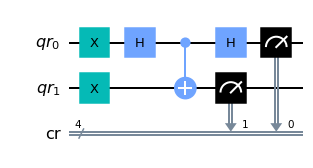

In [33]:
print(circuits[0].name)
circuits[0].draw(output="mpl")

circuit1629


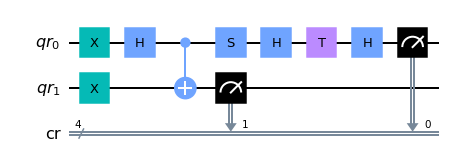

In [35]:
print(circuits[1].name)
circuits[1].draw(output="mpl")

In [39]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=50).result()  

In [44]:
result.get_counts(circuits[0])

{'0010': 19, '0001': 10, '0011': 15, '0000': 6}

In [45]:
result.get_counts(circuits[1])

{'0010': 17, '0001': 25, '0011': 6, '0000': 2}

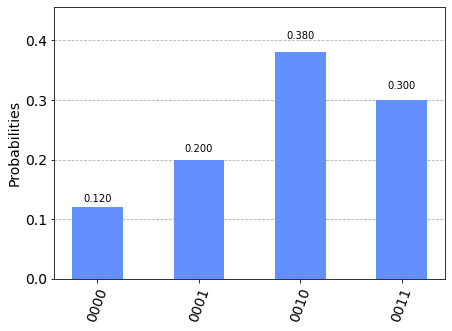

In [46]:
plot_histogram(result.get_counts(circuits[0]))

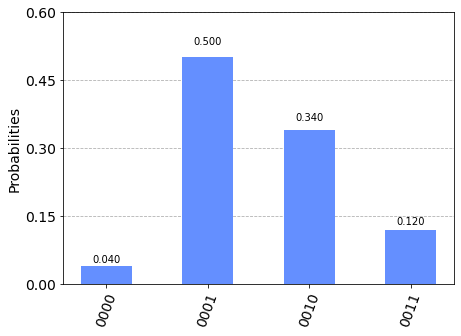

In [48]:
plot_histogram(result.get_counts(circuits[1]))

# SQKD